In [6]:
import torch
import torchaudio
import torch.nn as nn
from typing import Optional, Callable
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../../src')
import temporal_audio_vae

In [7]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        interpolation="nearest",
    )


def plot_spectrogram_diff(a, b, title=None):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(20, 5)
    if title:
        fig.suptitle(title)
    ax[0].set_title("A")
    ax[1].set_title("B")
    ax[2].set_title("diff")
    for i, s in enumerate([a, b, a - b]):
        image = ax[i].imshow(
            librosa.power_to_db(s),
            origin="lower",
            aspect="auto",
            interpolation="nearest",
        )
        fig.colorbar(image, ax=ax[i], orientation="horizontal", fraction=0.1)

In [9]:
FS = 48000

transform = temporal_audio_vae.transforms.Log1pMelSpec(
    sample_rate=44100,
    n_mels=512,
    n_fft=1024,
    win_length=128,  # win_length * 2
    hop_length=64,  # => 1024 frames
    griffin_lim_iter=32,
)
t = torch.arange(65535) / FS
x = torch.zeros_like(t)
for f in [440, 660, 880]:
    x += torch.sin(2 * torch.pi * f * t) * 0.3
# x = torch.randn(len(t))
print("original")
ipd.display(ipd.Audio(x, rate=FS))

original


mel spec size: torch.Size([512, 1024])
copyphase


/tmp/ipykernel_518300/3437193981.py:25: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.power_to_db(s),


griffinlim


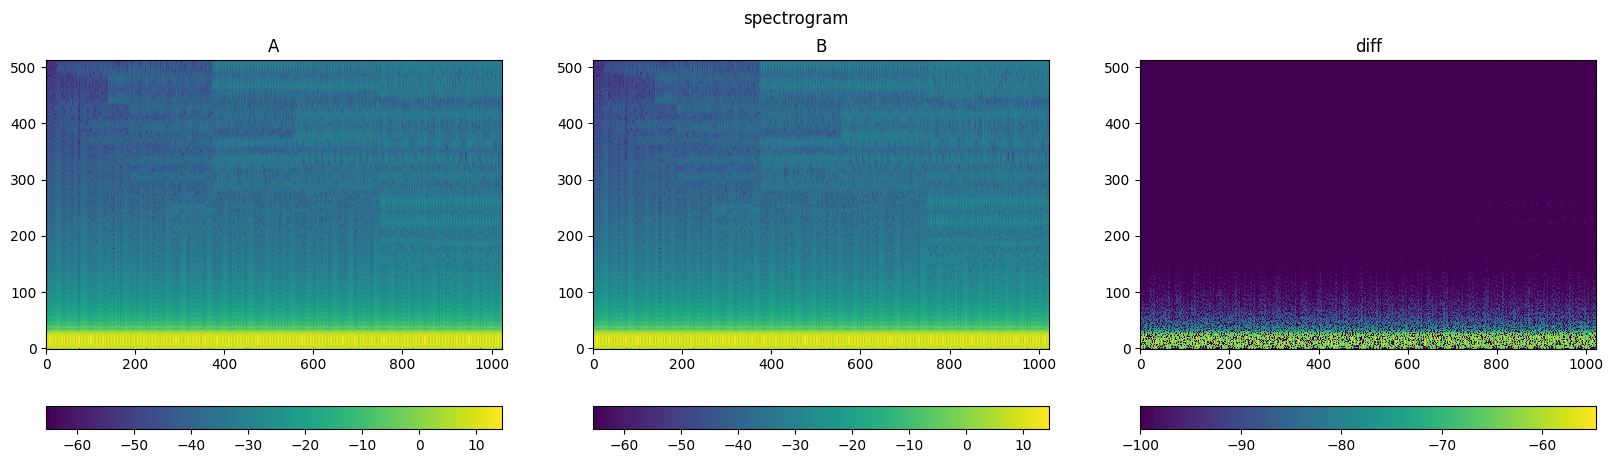

In [10]:
# transfo forward
specgram = transform.spectrogram(x)
mag, phase = torch.abs(specgram), torch.angle(specgram)
mel_specgram = transform.mel_scale(mag)  # dimension: (…, n_mels, time)

print(f"mel spec size: {mel_specgram.shape}")

# transfo backward
mag_hat = transform.inv_mel_scale(mel_specgram)
specgram_hat = mag * torch.exp(1j * phase)
x_hat_copy = transform.inv_spectrogram(specgram_hat)
x_hat_griffinlim = transform.griffin_lim(mag_hat)

plot_spectrogram_diff(specgram, specgram_hat, "spectrogram")

print("copyphase")
ipd.display(ipd.Audio(x_hat_copy, rate=FS))
print("griffinlim")
ipd.display(ipd.Audio(x_hat_griffinlim, rate=FS))